# **Experiment:** *In silico* phantom experiments

This notebook reproduces the results of the numerical experiments in

> C. Arrieta and C. A. Sing Long, "*Exact Local Recovery for Chemical Shift Imaging*."

You can use the following code to cite our work.
```bibtex
@article{arrieta_exact_2025, 
  title   = {Exact Local Recovery for Chemical Shift Imaging},  
  author  = {Arrieta, Cristóbal and Sing Long, Carlos A.}, 
  date    = {2025-03-31}
}
```

In [1]:
import numpy as np
import cvxpy as cp
import scipy.io as scpio

from os.path import exists

import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox

import sys

if "../.." not in sys.path:
    sys.path.insert(0, "../..")

In [2]:
# load precomputed data
LOAD_DATA = True
# layout for plots
PLT_LAYOUT = 'constrained'
BBOX_INCHES = Bbox([ [0, 0], [6, 6] ])
# save figures
def savefig(fname):
  plt.savefig(f'FIG/E03_{fname:s}.png', bbox_inches=BBOX_INCHES, dpi=300)
  plt.savefig(f'FIG/E03_{fname:s}.eps', bbox_inches=BBOX_INCHES)

## Contents

1. [Loading data](#loading-data)
2. [Setting up the problem](#setting-up-the-problem)
3. [Solving the problem](#solving-the-problem)
4. [Figures](#figures)

## Loading data

Load data for an *in silico* phantom containing water, fat and silicone.

In [3]:
# number of species
ns = 3
# names
SPECIES = [ 'WATER', 'FAT', 'SILICONE' ]
# undersampling in spatial dimensions
usamp = 1
# phantom code
DTE = '0.986'
# filename
fname = f'PHANTOM_NUM_WFS_DTE_{DTE}_FM_110'
# source folder
folder = '../../data/phantoms/'
# load .mat file
data = scpio.loadmat(folder + fname + '.mat')
# signal
So = data['imDataParams'][0, 0]['images']
So = So[:, :, :, :, :].squeeze()
So = So[::usamp, ::usamp, :]
# echo times
te = np.unique(data['imDataParams'][0, 0]['TE'].ravel())
# field
field = float(data['imDataParams'][0, 0]['FieldStrength'][0][0])
# true concentrations
co = data['xGT'][::usamp, ::usamp, :ns]
# true parameters
xio = data['xGT'][::usamp, ::usamp, ns]
# true pdff
pdffo = np.abs(co[:, :, 1]) / np.maximum(1E-32, np.linalg.norm(co, axis=2, ord=1))

In [4]:
# number of echo times
ne = te.size
# image shape
imshape = So.shape[:-1]
# number of pixels
npx = np.prod(So.shape[:-1])
# true signal
so = So.reshape((npx, ne))
# signal norm
so_nrm = np.linalg.norm(so, axis=1)

print(f'Echo times and echo spacing')
for I in range(ne):
  if I > 0:
    print(f'   Echo time {I:2d} : {te[I]:.6f} s  (Interval : {te[I] - te[I-1]:.6f} s)')
  else:
    print(f'   Echo time {I:2d} : {te[I]:.6f} s')

Echo times and echo spacing
   Echo time  0 : 0.001238 s
   Echo time  1 : 0.002224 s  (Interval : 0.000986 s)
   Echo time  2 : 0.003210 s  (Interval : 0.000986 s)
   Echo time  3 : 0.004196 s  (Interval : 0.000986 s)
   Echo time  4 : 0.005182 s  (Interval : 0.000986 s)
   Echo time  5 : 0.006168 s  (Interval : 0.000986 s)


We get the chemical shifts for the water, fat and silicone. 

In [5]:
from CSITools.routines.models import get_wfsilicone_model

In [6]:
shifts, weights = get_wfsilicone_model(field, mp=True)

## Setting up the problem

The residuals are implemented in the code as the ``CSIMap`` class. 

In [7]:
from CSITools.objects.csimap import CSIMap

In [8]:
R = CSIMap(So, te, shifts, weights, field, stol=0.0)

## Solving the problem

The Proximal Gradient Descent (PGD) solver regularizes the squared loss
$$
  L_R({\boldsymbol \xi}) = \frac{1}{2}\sum_{x} \|{\boldsymbol R}(\xi_x) {\boldsymbol s}_x\|_2^2
$$
with one of the convex and prox-capable regularizers provided. In this notebook we do not explicitly regularize, but we impose a constraint on the bound of the gradient by using the sum of indicator functions
$$
  P({\boldsymbol \xi}) = \mathbb{I}\{\operatorname{real}({\boldsymbol \xi}) \in C\} + \mathbb{I}\{\operatorname{imag}({\boldsymbol \xi}) \geq 0\}
$$
where
$$
  C = \{{\boldsymbol \phi} :\,\, \|\nabla{\boldsymbol \phi}_x \|_2 \leq \delta_x,\, x\in \Omega\}
$$
using Projected Gradient Descent (PGD).

The solver for this problem is implemented in ``CSIToolsSolverPGD``. 

In [9]:
from CSITools.solvers.pgd import CSIToolsSolverPGD

The solver requires an ``CSIMap`` instance.

In [10]:
solver = CSIToolsSolverPGD(R)

The solver also needs an instance of ``CSIToolsProx`` object. If no proximal operator is given, then it simply solves the NLS problem. Here we use the indicator function for the set above.

In [11]:
from CSITools.objects.prox import CSIToolsProxGradientBound

Here we can provide a single value $\varepsilon_g(v) \equiv \varepsilon_g$ or an array of bounds. Since ``RIDEALProxGradientBound`` uses forward finite-differences to compute the gradient, the number of bounds for an image of shape ``shape`` is ``(shape[0] - 1)*(shape[1] - 1)``.

In [12]:
# bound for regular voxels
gbnd = 30.0
# dimensional array
_gbnd = gbnd * np.ones((imshape[0]-1, imshape[1]-1))
# adjust the bound for voxels with zero signal intensity
So_nrm = so_nrm.reshape(So.shape[:2])
_gbnd[So_nrm[:imshape[0]-1, :imshape[1]-1] < 1E-3] = 1000

Pgbnd = CSIToolsProxGradientBound(shape=R.im_shape, gbound=_gbnd)

Some basic options can be set. More can be found on ``options``.

In [13]:
solver.options['max_itns'] = 2500
solver.options['print_every'] = 100
solver.options['stepRelTol'] = 1E-7
solver.options['stepAbsTol'] = 1E-4

Set the initial iterate and initial stepsize.

In [14]:
# initial iterate
xi_init = np.ones(xio.shape)
# initial stepsize
t = 1E+3

The solver handles three modes depending on an additional constraint in which only the fieldmap is minimized, i.e., the real part of ${\boldsymbol\xi}$, only $R_2^*$ is minimized, i.e., the imaginary part of ${\boldsymbol\xi}$, or both. These are used with ``mode='f'``, ``mode='r'`` and ``mode='both'`` respectively. ``mode='both'`` is the default.

Internally the optimization variable is always complex. If the initial iterate is complex and ``mode='f'`` or ``mode='r'`` is used, then the corresponding imaginary or real part is preserved. This is useful to optimize over a fixed variable.

We can provide in ``prox`` a single ``CSIToolsProx``. 

In [15]:
# filename
fname = f'DAT/E03_RECOVERY_DTE_{DTE}_USAMP{usamp}_GBND{gbnd:.2f}.npz'

if LOAD_DATA and exists(fname):
  xi_rec = np.load(fname)['xi_rec']
else:
  xi_rec = solver.solve(xi_init, t, prox=Pgbnd, mode='both')
  # save
  np.savez_compressed(fname, xi_rec=xi_rec)

To obtain the predicted voxel signals and concentrations we use ``signal`` and ``concentrations`` from the ``CSIMap``.

In [16]:
# predicted concentrations
c = R.concentration(xi_rec)
# predicted signal
S = R.signal(xi_rec)
# predicted pdff
pdff = np.abs(c[:, :, 1]) / np.maximum(1E-32, np.linalg.norm(c, axis=2, ord=1))

Plot results.

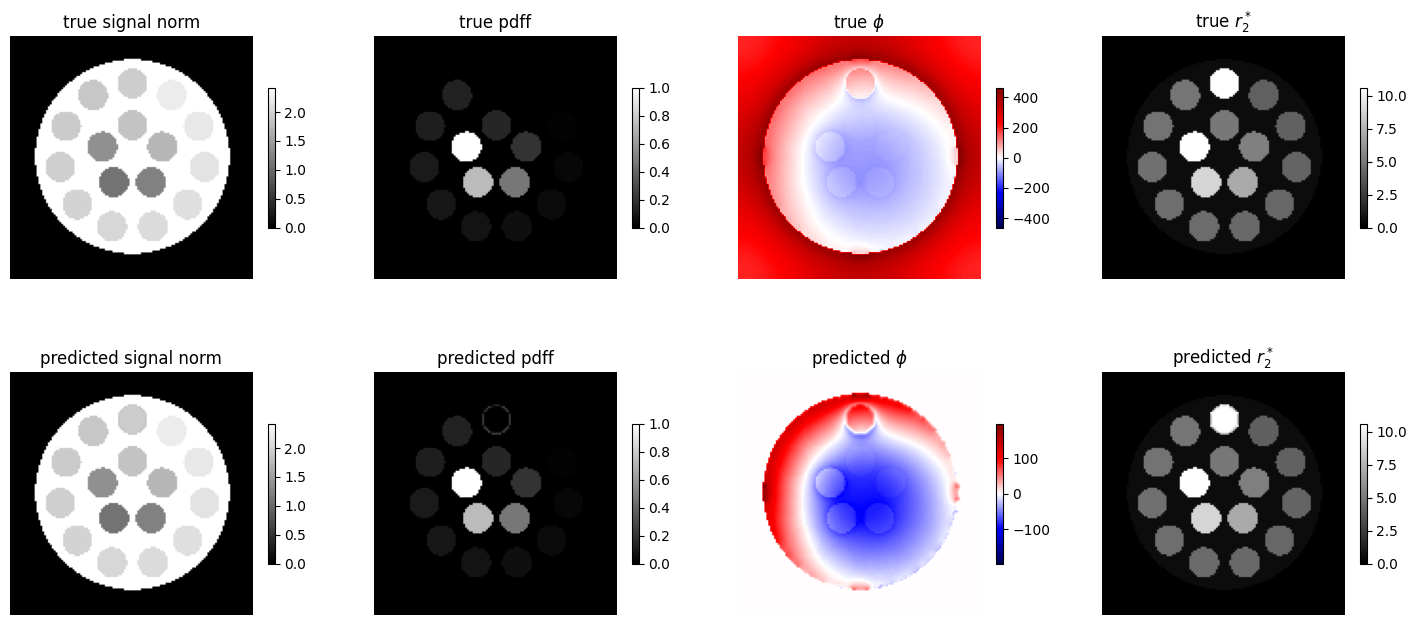

In [17]:
fo_max = np.abs(xio.real).max()
f_rec_max = np.abs(xi_rec.real).max()

fig, axs = plt.subplots(2, 4, figsize=(18, 8))
# first row
_axs = axs[0]

im0 = _axs[0].imshow(np.linalg.norm(So, axis=2), origin='lower', cmap='gray', aspect='equal')
_axs[0].axis('off')
_axs[0].set_title('true signal norm')
plt.colorbar(im0, ax=_axs[0], shrink=0.5)

im1 = _axs[1].imshow(pdffo, origin='lower', cmap='gray', aspect='equal')
_axs[1].axis('off')
_axs[1].set_title('true pdff')
plt.colorbar(im1, ax=_axs[1], shrink=0.5)

im2 = _axs[2].imshow(xio.real, origin='lower', cmap='seismic', vmin=-fo_max, vmax=+fo_max, aspect='equal')
_axs[2].axis('off')
_axs[2].set_title('true $\\phi$')
plt.colorbar(im2, ax=_axs[2], shrink=0.5)

im3 = _axs[3].imshow(xio.imag, origin='lower', cmap='gray', aspect='equal')
_axs[3].axis('off')
_axs[3].set_title('true $r_2^*$')
plt.colorbar(im3, ax=_axs[3], shrink=0.5)

# second row
_axs = axs[1]

im0 = _axs[0].imshow(np.linalg.norm(S, axis=2), origin='lower', cmap='gray', aspect='equal')
_axs[0].axis('off')
_axs[0].set_title('predicted signal norm')
plt.colorbar(im0, ax=_axs[0], shrink=0.5)

im1 = _axs[1].imshow(pdff, origin='lower', cmap='gray', aspect='equal')
_axs[1].axis('off')
_axs[1].set_title('predicted pdff')
plt.colorbar(im1, ax=_axs[1], shrink=0.5)

im2 = _axs[2].imshow(xi_rec.real, origin='lower', cmap='seismic', vmin=-f_rec_max, vmax=+f_rec_max, aspect='equal')
_axs[2].axis('off')
_axs[2].set_title('predicted $\\phi$')
plt.colorbar(im2, ax=_axs[2], shrink=0.5)

im3 = _axs[3].imshow(xi_rec.imag, origin='lower', cmap='gray', aspect='equal')
_axs[3].axis('off')
_axs[3].set_title('predicted $r_2^*$')
plt.colorbar(im3, ax=_axs[3], shrink=0.5)

plt.show()

## Figures

### Concentrations

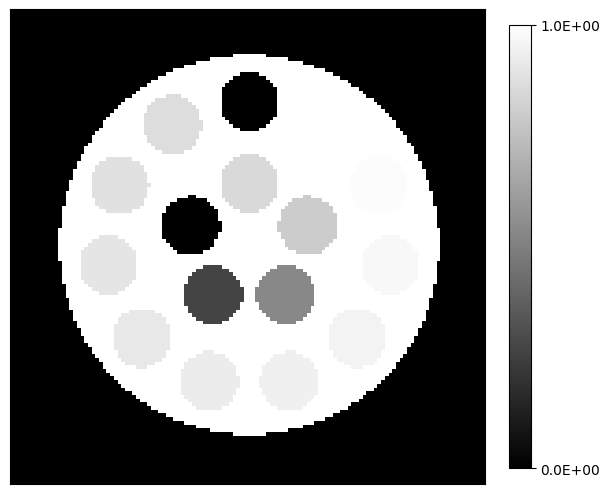

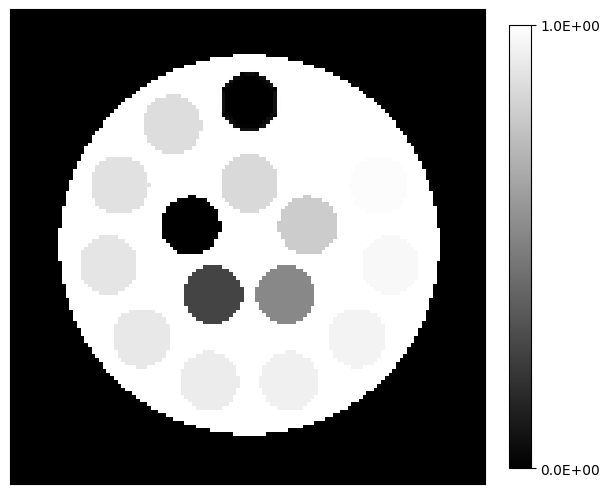

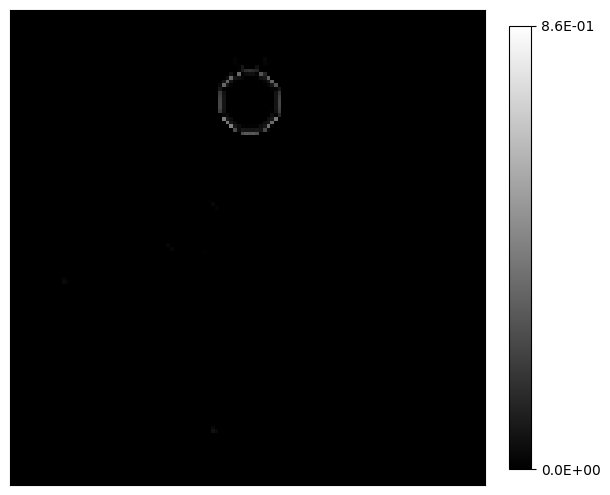

Error in WATER
  MSE:      2.001872E-04
  SNR:      3.337745E+01
  PSNR:     3.698564E+01


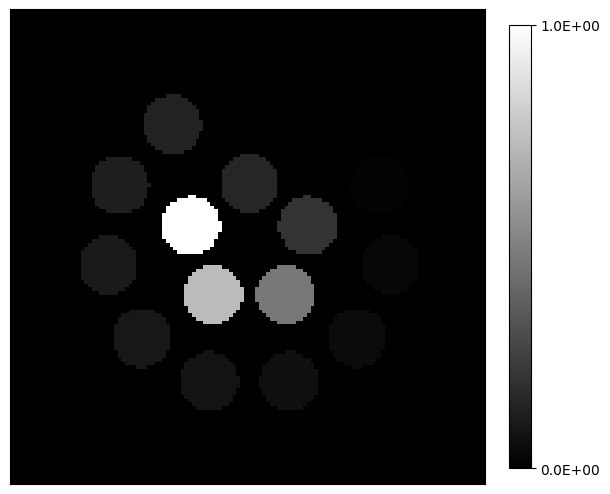

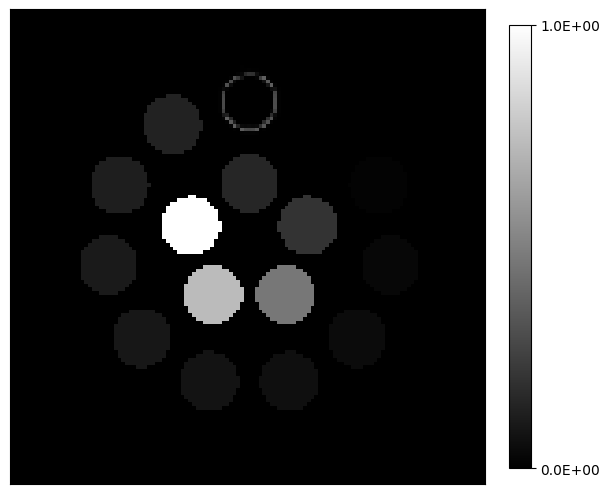

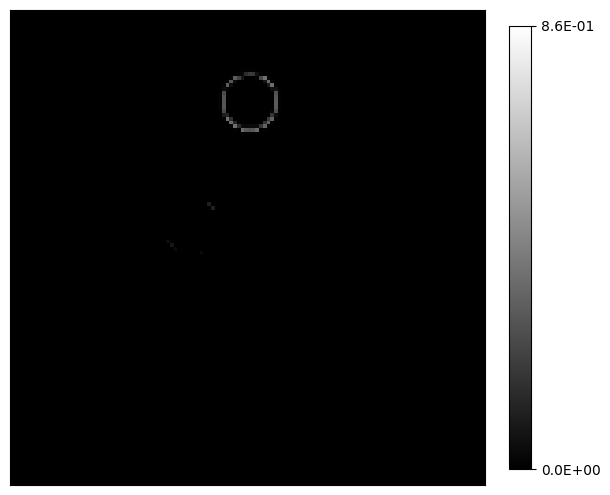

Error in FAT
  MSE:      2.064309E-04
  SNR:      2.042004E+01
  PSNR:     3.685225E+01


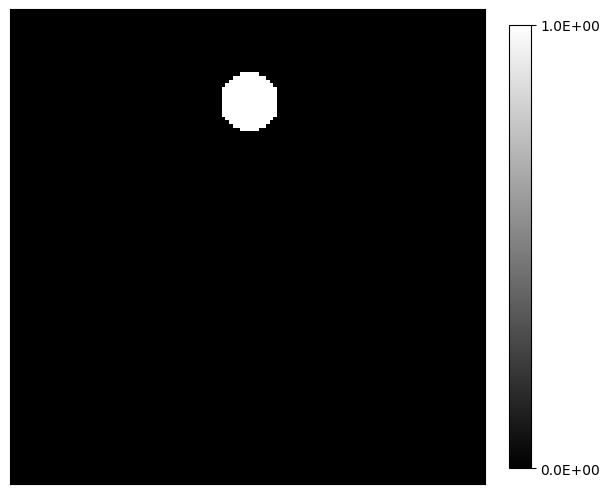

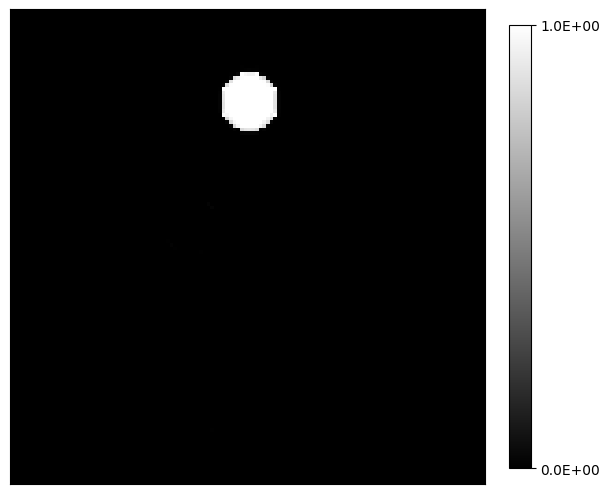

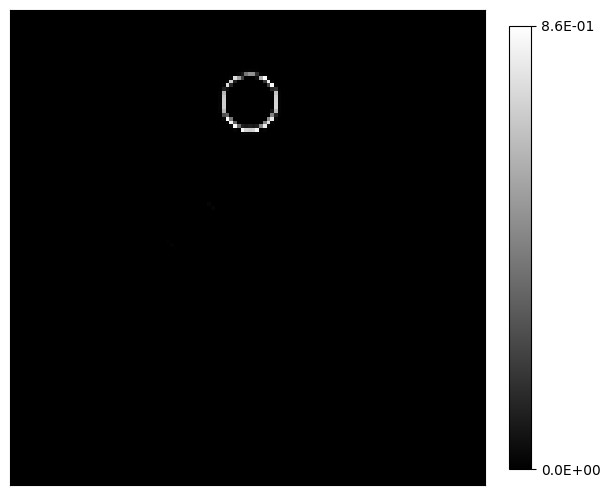

Error in SILICONE
  MSE:      1.160612E-03
  SNR:      1.013149E+01
  PSNR:     2.935313E+01


In [18]:
for I, SLABEL in enumerate(SPECIES):
  plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
  plt.imshow(np.abs(co[:, :, I]), origin='lower', vmin=0.0, vmax=np.abs(co).max(), cmap='gray', aspect='auto')
  plt.xlim([ 0, imshape[0] - 1 ])
  plt.ylim([ 0, imshape[1] - 1 ])
  plt.xticks([])
  plt.yticks([])
  plt.axis('scaled')
  plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, np.abs(co).max() ])

  savefig(f'C0_{SLABEL}')

  plt.show()

  plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
  plt.imshow(np.abs(c[:, :, I]), origin='lower', vmin=0.0, vmax=np.abs(co).max(), cmap='gray', aspect='auto')
  plt.xlim([ 0, imshape[0] - 1 ])
  plt.ylim([ 0, imshape[1] - 1 ])
  plt.xticks([])
  plt.yticks([])
  plt.axis('scaled')
  plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, np.abs(co).max() ])

  savefig(f'C_{SLABEL}_DTE_{DTE}_USAMP{usamp}_GBND{gbnd:.2f}')

  plt.show()

  plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
  plt.imshow(np.abs(c[:, :, I] - co[:, :, I]), origin='lower', vmin=0.0, vmax=np.abs(c - co).max(), cmap='gray', aspect='auto')
  plt.xlim([ 0, imshape[0] - 1 ])
  plt.ylim([ 0, imshape[1] - 1 ])
  plt.xticks([])
  plt.yticks([])
  plt.axis('scaled')
  plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, np.abs(c - co).max() ])

  savefig(f'dC_{SLABEL}_DTE_{DTE}_USAMP{usamp}_GBND{gbnd:.2f}')

  plt.show()

  # error metrics
  err_mse = np.linalg.norm((c - co)[:, :, I].ravel()) ** 2 / npx
  err_snr = 10 * np.log10(np.linalg.norm(co[:, :, I].ravel()) ** 2 / np.linalg.norm((c - co)[:, :, I].ravel()) ** 2)
  err_psnr = 10 * np.log10(np.abs(co[:, :, I]).max() ** 2 / (np.linalg.norm((c - co)[:, :, I].ravel()) ** 2 / npx))

  print(f'Error in {SLABEL}')
  print(f'  MSE:      {err_mse:.6E}')
  print(f'  SNR:      {err_snr:.6E}')
  print(f'  PSNR:     {err_psnr:.6E}')

### Fieldmap

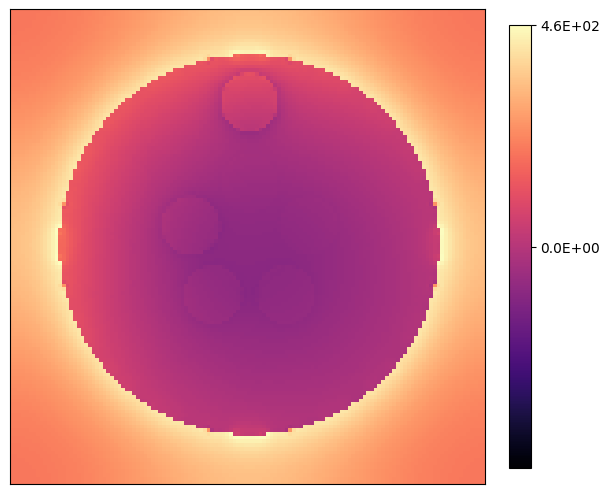

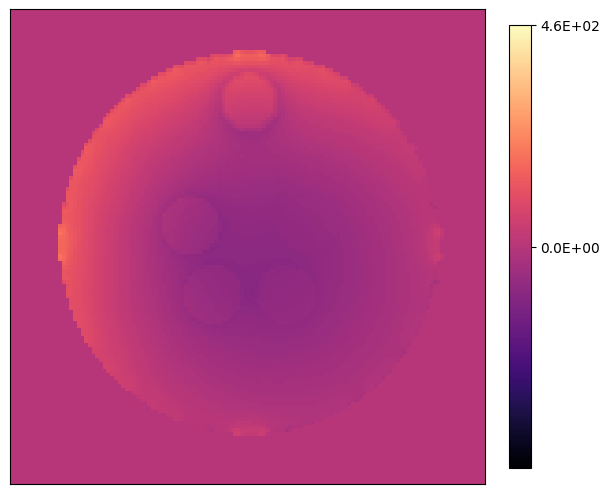

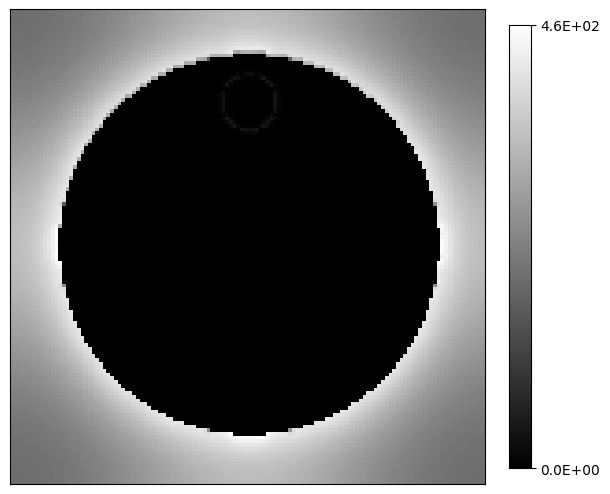

Error in fieldmap
  MSE:      4.713989E+04
  SNR:      2.168605E-01
  PSNR:     6.607616E+00


In [19]:
plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
plt.imshow(xio.real, origin='lower', vmin=-np.abs(xio.real).max(), vmax=+np.abs(xio.real).max(), cmap='magma', aspect='auto')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, np.abs(xio.real).max() ])

savefig(f'PH0')

plt.show()

plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
plt.imshow(xi_rec.real, origin='lower', vmin=-np.abs(xio.real).max(), vmax=+np.abs(xio.real).max(), cmap='magma', aspect='auto')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, np.abs(xio.real).max() ])

savefig(f'PH_DTE_{DTE}_USAMP{usamp}_GBND{gbnd:.2f}')

plt.show()

plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
plt.imshow(np.abs((xi_rec - xio).real), origin='lower', vmin=0.0, vmax=np.abs((xi_rec - xio).real).max(), cmap='gray', aspect='auto')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, np.abs((xi_rec - xio).real).max() ])

savefig(f'dPH_DTE_{DTE}_USAMP{usamp}_GBND{gbnd:.2f}')

plt.show()

# error metrics
err_mse = np.linalg.norm(((xi_rec - xio).real).ravel()) ** 2 / npx
err_snr = 10 * np.log10(np.linalg.norm(xio.real.ravel()) ** 2 / np.linalg.norm(((xi_rec - xio).real).ravel()) ** 2)
err_psnr = 10 * np.log10(np.abs(xio.real).max() ** 2 / (np.linalg.norm(((xi_rec - xio).real).ravel()) ** 2 / npx))

print(f'Error in fieldmap')
print(f'  MSE:      {err_mse:.6E}')
print(f'  SNR:      {err_snr:.6E}')
print(f'  PSNR:     {err_psnr:.6E}')

### $R_2^*$

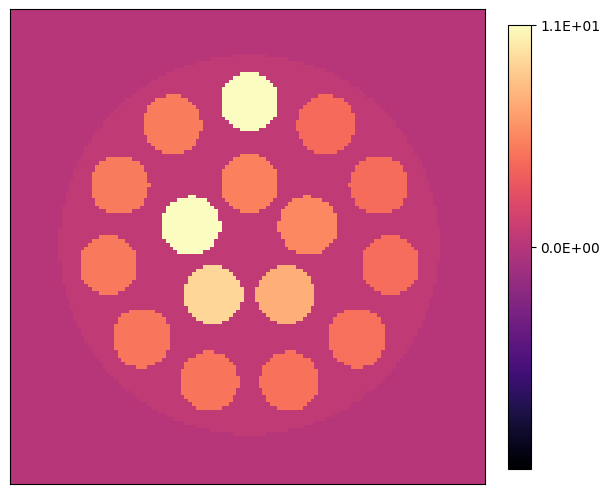

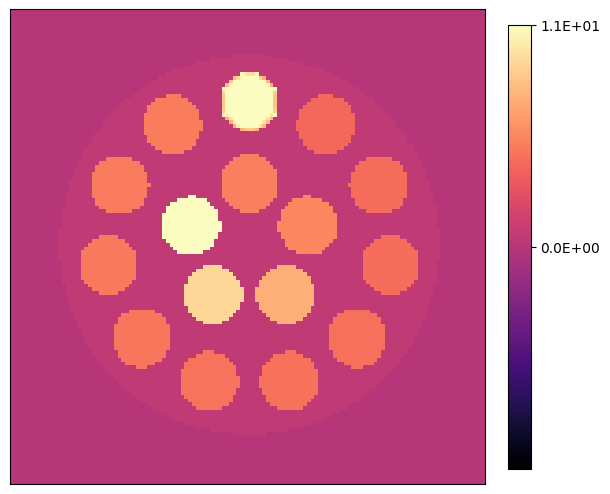

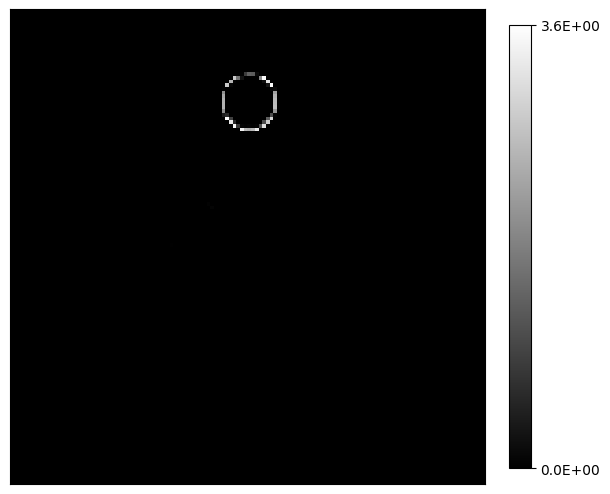

Error in R2*
  MSE:      1.557517E-02
  SNR:      2.673612E+01
  PSNR:     3.859025E+01


In [20]:
plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
plt.imshow(xio.imag, origin='lower', vmin=-np.abs(xio.imag).max(), vmax=+np.abs(xio.imag).max(), cmap='magma', aspect='auto')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, np.abs(xio.imag).max() ])

savefig(f'R20')

plt.show()

plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
plt.imshow(xi_rec.imag, origin='lower', vmin=-np.abs(xio.imag).max(), vmax=+np.abs(xio.imag).max(), cmap='magma', aspect='auto')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, np.abs(xio.imag).max() ])

savefig(f'R2_DTE_{DTE}_USAMP{usamp}_GBND{gbnd:.2f}')

plt.show()

plt.figure(figsize=(6, 6), layout=PLT_LAYOUT)
plt.imshow(np.abs((xi_rec - xio).imag), origin='lower', vmin=0.0, vmax=np.abs((xi_rec - xio).imag).max(), cmap='gray', aspect='auto')
plt.xlim([ 0, imshape[0] - 1 ])
plt.ylim([ 0, imshape[1] - 1 ])
plt.xticks([])
plt.yticks([])
plt.axis('scaled')
plt.colorbar(shrink=0.75, format=lambda x, _: f'{x:.1E}', ticks=[ 0.0, np.abs((xi_rec - xio).imag).max() ])

savefig(f'dR2_DTE_{DTE}_USAMP{usamp}_GBND{gbnd:.2f}')

plt.show()

# error metrics
err_mse = np.linalg.norm(((xi_rec - xio).imag).ravel()) ** 2 / npx
err_snr = 10 * np.log10(np.linalg.norm(xio.imag.ravel()) ** 2 / np.linalg.norm(((xi_rec - xio).imag).ravel()) ** 2)
err_psnr = 10 * np.log10(np.abs(xio.imag).max() ** 2 / (np.linalg.norm(((xi_rec - xio).imag).ravel()) ** 2 / npx))

print(f'Error in R2*')
print(f'  MSE:      {err_mse:.6E}')
print(f'  SNR:      {err_snr:.6E}')
print(f'  PSNR:     {err_psnr:.6E}')